In [1]:
# This is needed to be able to build the model
# Upgrade TensorFlow and Keras to specific versions
!pip install --upgrade tensorflow==2.17.0
!pip install --upgrade keras==3.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.2 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.17.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.17.0 which is incompatible.
tf-keras 2.16.0 requires tensorfl

In [2]:
from warnings import filterwarnings
filterwarnings(action="ignore")

import cv2
import imageio
from IPython.display import Image, display

import numpy as np
import pandas as pd
from glob import glob

from tqdm.auto import tqdm
tqdm.pandas()

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import Input, layers, Sequential, Model, callbacks, optimizers

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

2024-10-07 01:55:24.560764: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-07 01:55:24.583212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-07 01:55:24.589587: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class Config:
    random_state = 2024
    test_size = .3
    batch_size = 32
    data_path = "/kaggle/input/ucf101"

In [4]:
project_config = Config()

In [5]:
def GetVideoDf(path:str):
    data = dict(file_path=[], label=[])
    for i in tqdm(glob(path+"/**/**/**/**.avi")):
        data["file_path"].append(i)
        data["label"].append(i.split("/")[-2])
    return pd.DataFrame(data)

In [6]:
df = GetVideoDf(path=project_config.data_path)

print(df.shape)

df.head()

  0%|          | 0/13320 [00:00<?, ?it/s]

(13320, 2)


,file_path,label
0,/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/...,HorseRace
1,/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/...,HorseRace
2,/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/...,HorseRace
3,/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/...,HorseRace
4,/kaggle/input/ucf101/UCF101/UCF-101/HorseRace/...,HorseRace


In [7]:
df["label"].value_counts().to_dict()

{'CricketShot': 167,
 'TennisSwing': 166,
 'PlayingDhol': 164,
 'HorseRiding': 164,
 'PlayingCello': 164,
 'BoxingPunchingBag': 163,
 'Drumming': 161,
 'ShavingBeard': 161,
 'PlayingGuitar': 160,
 'BenchPress': 160,
 'Punch': 160,
 'IceDancing': 158,
 'PlayingSitar': 157,
 'BandMarching': 155,
 'PlayingFlute': 155,
 'Bowling': 155,
 'WritingOnBoard': 152,
 'PlayingDaf': 151,
 'Diving': 150,
 'BaseballPitch': 150,
 'HammerThrow': 150,
 'Billiards': 150,
 'PoleVault': 149,
 'HeadMassage': 147,
 'SoccerJuggling': 147,
 'ApplyEyeMakeup': 145,
 'Archery': 145,
 'JumpRope': 144,
 'Shotput': 144,
 'RockClimbingIndoor': 144,
 'Kayaking': 141,
 'Hammering': 140,
 'TableTennisShot': 140,
 'CricketBowling': 139,
 'GolfSwing': 139,
 'CliffDiving': 138,
 'SoccerPenalty': 137,
 'Rowing': 137,
 'FrontCrawl': 137,
 'Typing': 136,
 'Mixing': 136,
 'Skiing': 135,
 'Basketball': 134,
 'BoxingSpeedBag': 134,
 'Biking': 134,
 'SalsaSpin': 133,
 'Nunchucks': 132,
 'BabyCrawling': 132,
 'BasketballDunk': 131

## Filter out just 5 kinds of videos to classify due to limited computational resources

In [8]:
filtered_df = df[df["label"].isin(["CricketShot",
                                   "TennisSwing",
                                   "PlayingDhol",
                                   "HorseRiding",
                                   "PlayingCello"
                                   ])].reset_index(drop=True)

print(filtered_df.shape)

filtered_df.head()

(825, 2)


,file_path,label
0,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello
1,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello
2,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello
3,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello
4,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello


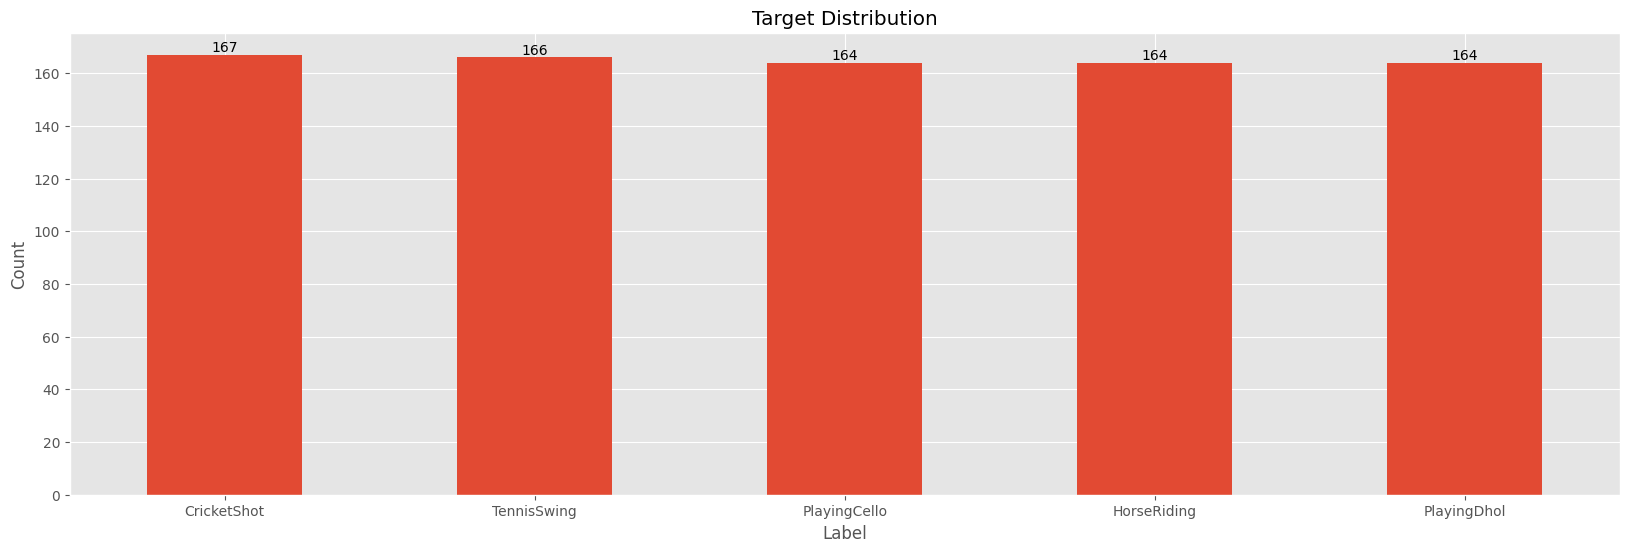

In [9]:
target_dist = filtered_df["label"].value_counts().plot(kind="bar",
                                                       figsize=(20, 6), 
                                                       xlabel="Label",
                                                       ylabel="Count",
                                                       title="Target Distribution")

for p in target_dist.patches:
    height = p.get_height()  
    target_dist.text(p.get_x() + p.get_width() / 2,  
                     height,  
                     f'{int(height)}',  
                     ha='center',  
                     va='bottom')  
    
target_dist.set_xticklabels(labels=target_dist.get_xticklabels(), rotation=0)

plt.show()

In [10]:
encoder = LabelEncoder()

In [11]:
filtered_df["encoded_label"] = encoder.fit_transform(filtered_df["label"])

In [12]:
filtered_df

,file_path,label,encoded_label
0,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello,2
1,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello,2
2,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello,2
3,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello,2
4,/kaggle/input/ucf101/UCF101/UCF-101/PlayingCel...,PlayingCello,2
...,...,...,...
820,/kaggle/input/ucf101/UCF101/UCF-101/TennisSwin...,TennisSwing,4
821,/kaggle/input/ucf101/UCF101/UCF-101/TennisSwin...,TennisSwing,4
822,/kaggle/input/ucf101/UCF101/UCF-101/TennisSwin...,TennisSwing,4
823,/kaggle/input/ucf101/UCF101/UCF-101/TennisSwin...,TennisSwing,4


In [13]:
label_index = {j:i for i, j in zip(encoder.classes_, range(len(encoder.classes_)))}

label_index

{0: 'CricketShot',
 1: 'HorseRiding',
 2: 'PlayingCello',
 3: 'PlayingDhol',
 4: 'TennisSwing'}

In [14]:
def GetFrames(file_paths: list, fps: int):
    frames_per_video = []
    
    for path in tqdm(file_paths):
        extracted_frames = []
        video = cv2.VideoCapture(path)
        
        if not video.isOpened():
            print(f"Error loading {path}")
            continue  
        
        total_frames_per_video = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        strides = total_frames_per_video // fps if fps > 0 else 0
        
        if strides == 0:
            print(f"Not enough frames in: {path}, total_frames_per_video: {total_frames_per_video}")
            continue
        
        frame_count = 0
        while True:
            suc, frame = video.read()
                
            if not suc:
                break  
                    
            if (frame_count % strides) == 0:
                bgr_2_rbg = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
                transform = A.Compose([
                    A.Resize(height=64, width=64, p=1),
                    A.Normalize(p=1)
                ])
                
                augmented_image = transform(image=bgr_2_rbg)["image"]
                extracted_frames.append(augmented_image)
                
            frame_count += 1
            
            if len(extracted_frames) >= fps:
                break  
        
        frames_per_video.append(extracted_frames)
        video.release()
        
    return np.array(frames_per_video)

In [15]:
X = GetFrames(filtered_df["file_path"], 30)

  0%|          | 0/825 [00:00<?, ?it/s]

In [16]:
X.shape

(825, 30, 64, 64, 3)

In [17]:
def ShowVideo(frames):
    clipped_frame = np.clip(frames*255, 0, 255).astype(np.uint8)
    imageio.mimsave(f"video.gif", clipped_frame, fps=frames.shape[0])
    display(Image(filename="./video.gif", embed=True, height=400, width=400))

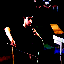

In [18]:
ShowVideo(X[30])

In [19]:
y = filtered_df["encoded_label"]

In [20]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, 
                                                test_size=project_config.test_size,
                                                stratify=y, 
                                                shuffle=True,
                                                random_state=project_config.random_state)

print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(577, 30, 64, 64, 3) (248, 30, 64, 64, 3) (577,) (248,)


In [21]:
ytrain = to_categorical(ytrain)
ytest = to_categorical(ytest)

In [22]:
def BuildModel(input_shape: tuple, num_classes: int):
    resnet_model = ResNet50(weights='imagenet',
                            include_top=False, 
                            input_shape=input_shape[1:])

    # Reshape input for time distributed layer
    input_layer = Input(shape=input_shape)
    reshaped_input = layers.TimeDistributed(resnet_model)(input_layer)

    # Flatten spatial features
    flattened_features = layers.TimeDistributed(layers.Flatten())(reshaped_input)

    # LSTM layer for temporal processing
    lstm_output = layers.LSTM(64, return_sequences=True)(flattened_features)
    lstm_output = layers.Dropout(0.2)(lstm_output)

    # Apply spatial attention
    attention = layers.Attention()([lstm_output, lstm_output])
    attended_features = layers.Multiply()([lstm_output, attention])

    # Global average pooling to obtain a fixed-size representation
    global_avg_pooled = layers.GlobalAveragePooling1D()(attended_features)

    # Dense layer for classification
    output = layers.Dense(num_classes, activation='softmax')(global_avg_pooled)

    # Create the model
    model = Model(inputs=input_layer, outputs=output)

    # Display the model summary
    model.summary()

    return model

In [23]:
attention_model = BuildModel(input_shape=X.shape[1:], num_classes=len(label_index))

I0000 00:00:1728266177.509422      23 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728266177.520545      23 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728266177.520755      23 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728266177.522845      23 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 3)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 2, 2,  │ 23,587,712 │ input_layer_1[0]… │
│ (TimeDistributed)   │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_1  │ (None, 30, 8192)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 30, 64)    │  2,113,792 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 30, 64)    │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 64)    │          0 │ dropout[0][0],    │
│ (Attention)         │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 30, 64)    │          0 │ dropout[0][0],    │
│                     │                   │            │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 5)         │        325 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,701,829 (98.04 MB)

 Trainable params: 25,648,709 (97.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

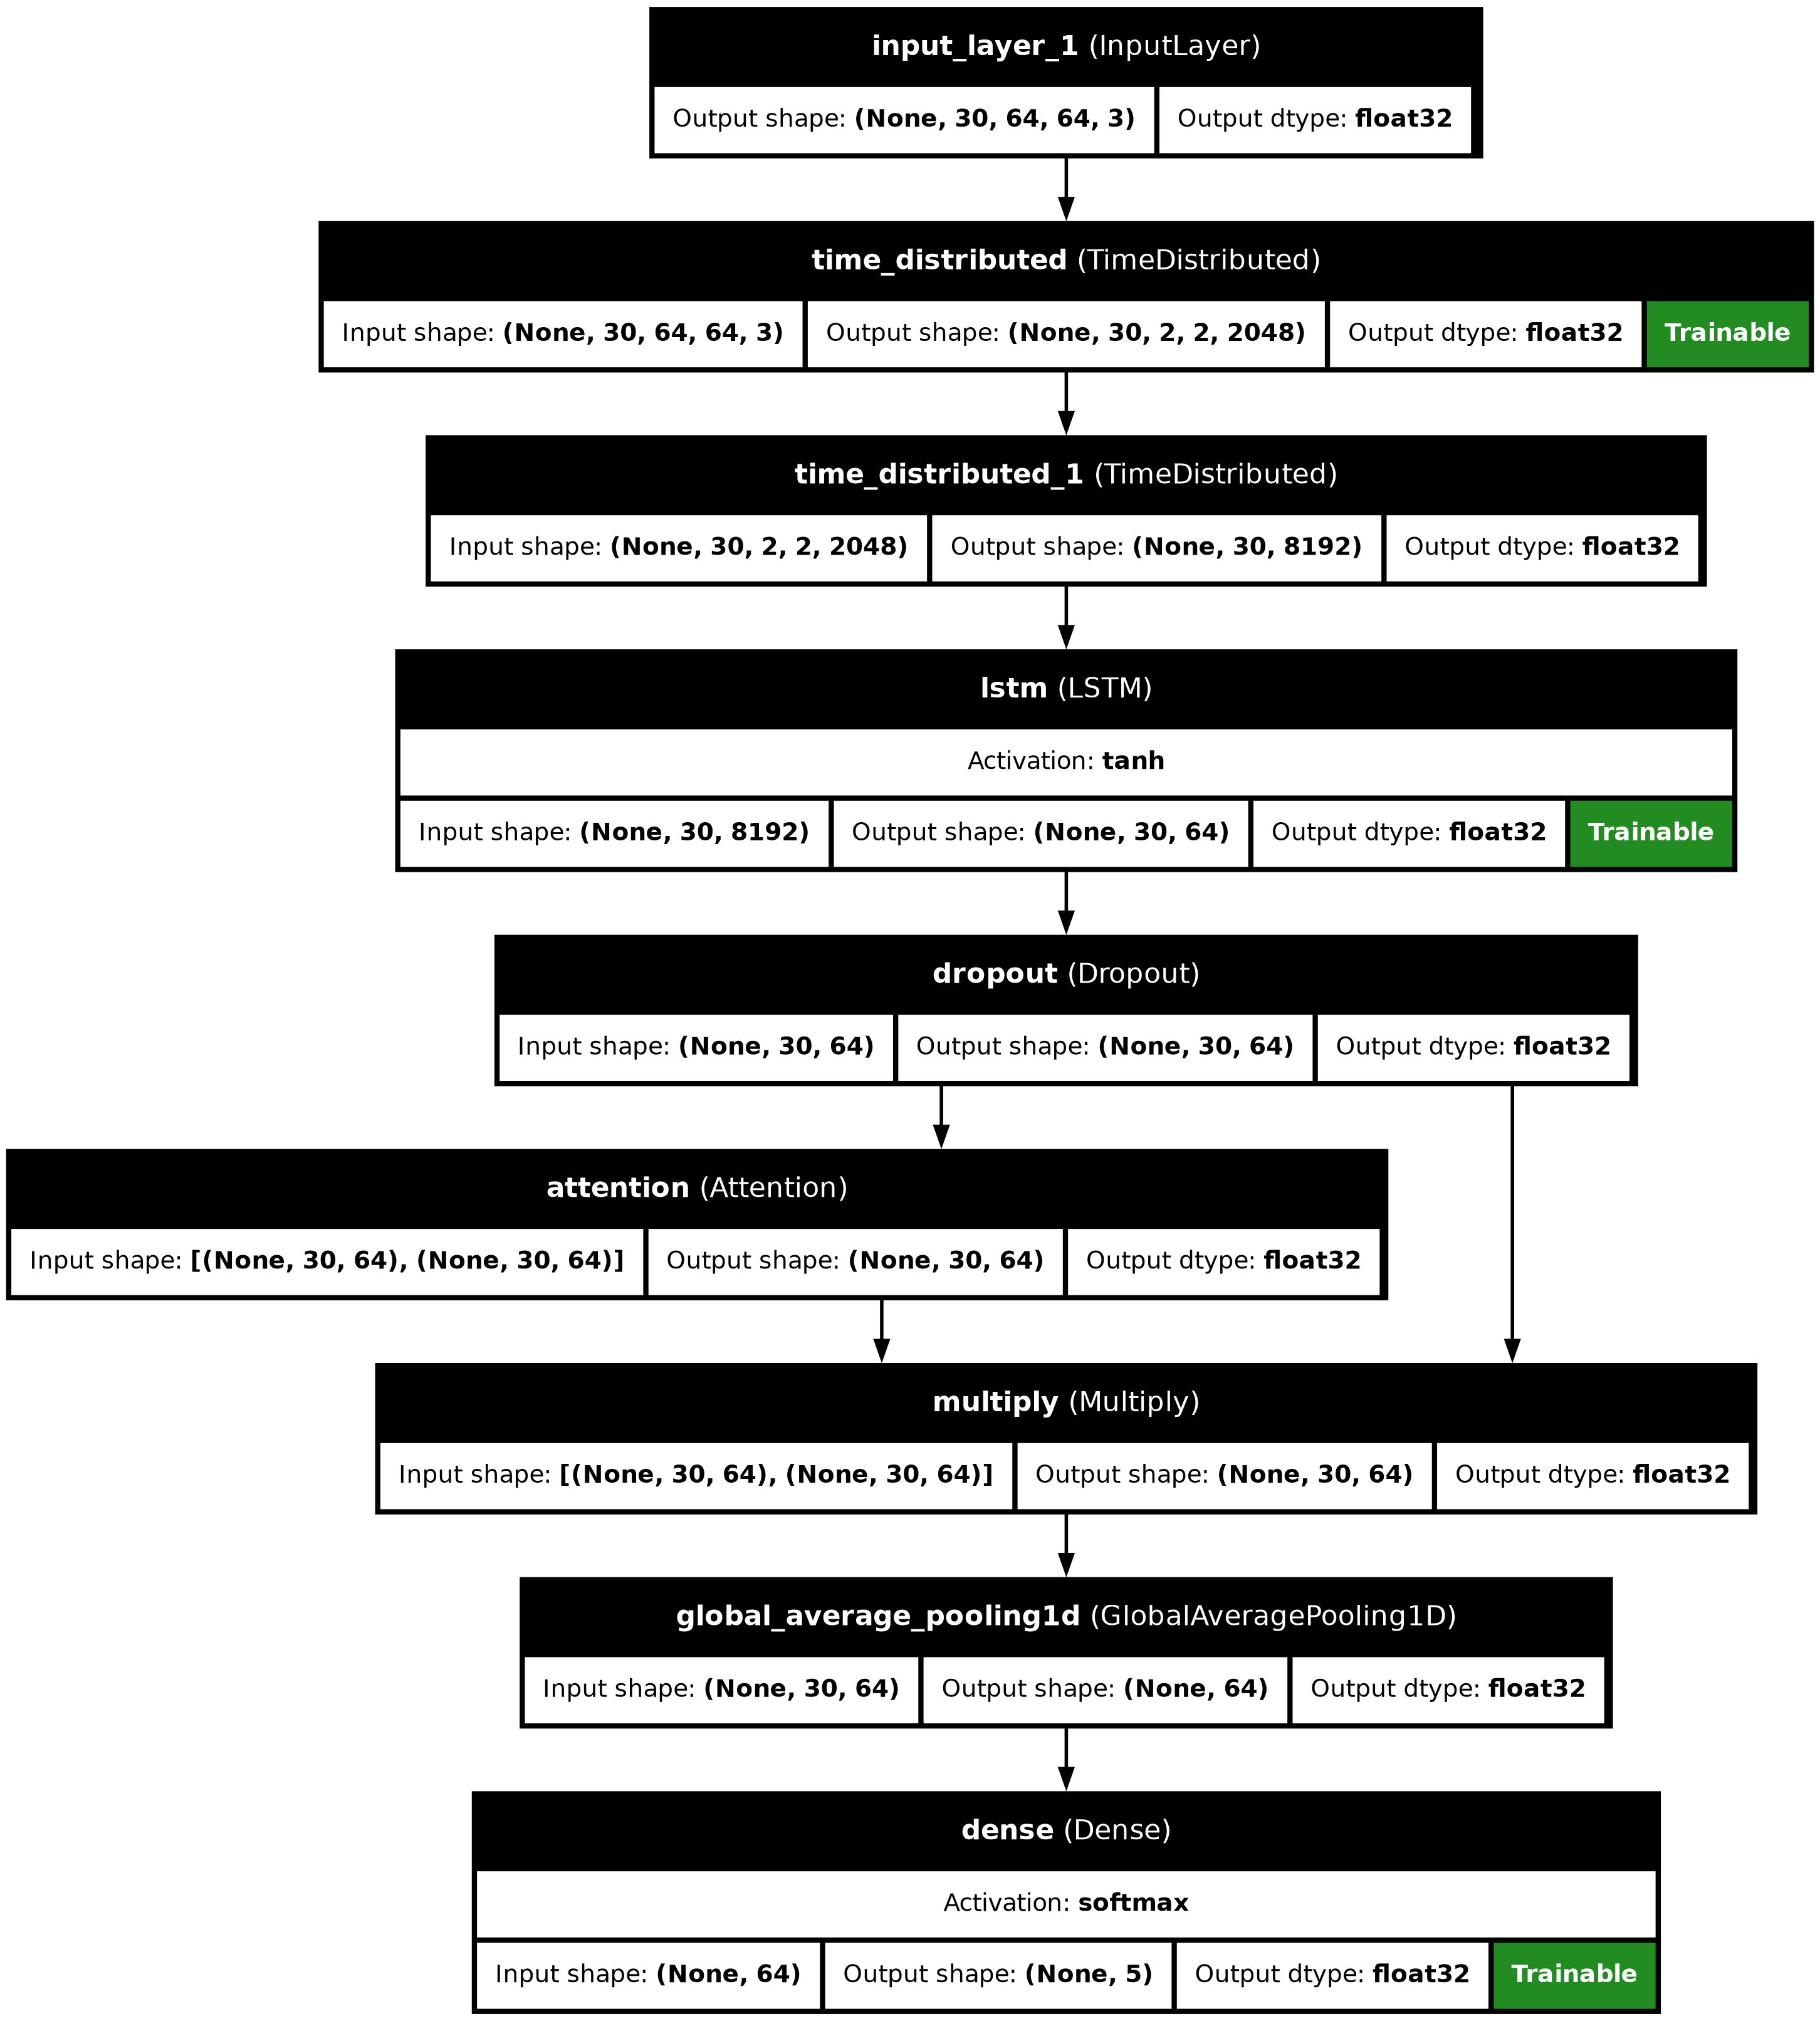

In [24]:
plot_model(attention_model,
           to_file='model.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True,
           show_layer_activations=True,
           show_trainable=True,)

In [25]:
def RecallScore(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def PrecisionScore(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1Score(y_true, y_pred):
    precision = PrecisionScore(y_true, y_pred)
    recall = RecallScore(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [26]:
attention_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy',RecallScore, PrecisionScore, F1Score])

In [27]:
# Check if a GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPU(s): {gpus}")
else:
    print("No GPU available.")

Available GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
history = attention_model.fit(Xtrain,ytrain, 
                              validation_split=.2,
                              batch_size=project_config.batch_size,
                              epochs=50,
                              callbacks=[callbacks.EarlyStopping(patience=10), 
                                         callbacks.LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else float(lr * K.exp(-0.1)))])

Epoch 1/50


W0000 00:00:1728266674.408140    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.447390    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.448072    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.448769    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.449446    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.450096    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.463194    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.463912    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266674.477583    3383 gp

 1/15 ━━━━━━━━━━━━━━━━━━━━ 1:55:37 496s/step - accuracy: 0.2812 - f1_score: 0.0000e+00 - loss: 1.6175 - precision_score: 0.0000e+00 - recall_score: 0.0000e+00

W0000 00:00:1728266678.991267    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.002944    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.003429    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.003935    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.004422    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.004911    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.005783    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.008397    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266679.008919    3386 gp

14/15 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2758 - f1_score: 0.0000e+00 - loss: 1.5748 - precision_score: 0.0000e+00 - recall_score: 0.0000e+00

W0000 00:00:1728266697.988652    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.989250    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.989777    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.990305    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.990829    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.991350    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.991871    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.992396    3386 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266697.992940    3386 gp

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2794 - f1_score: 0.0000e+00 - loss: 1.5714 - precision_score: 0.0000e+00 - recall_score: 0.0000e+00

W0000 00:00:1728266699.694988    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.695568    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.696241    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.696777    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.697343    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.697892    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.698531    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.699085    3383 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728266699.700533    3383 gp

15/15 ━━━━━━━━━━━━━━━━━━━━ 579s 6s/step - accuracy: 0.2825 - f1_score: 0.0000e+00 - loss: 1.5685 - precision_score: 0.0000e+00 - recall_score: 0.0000e+00 - val_accuracy: 0.2414 - val_f1_score: 0.0000e+00 - val_loss: 1.6211 - val_precision_score: 0.0000e+00 - val_recall_score: 0.0000e+00 - learning_rate: 1.0000e-05
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6624 - f1_score: 0.0753 - loss: 1.2659 - precision_score: 0.7196 - recall_score: 0.0405 - val_accuracy: 0.7931 - val_f1_score: 0.0390 - val_loss: 1.2537 - val_precision_score: 0.5000 - val_recall_score: 0.0203 - learning_rate: 1.0000e-05
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.8587 - f1_score: 0.3010 - loss: 1.0612 - precision_score: 1.0000 - recall_score: 0.1816 - val_accuracy: 0.9052 - val_f1_score: 0.2558 - val_loss: 1.0401 - val_precision_score: 1.0000 - val_recall_score: 0.1516 - learning_rate: 1.0000e-05
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9687 - f1_score:

In [29]:
result = pd.DataFrame(history.history)


result

,accuracy,f1_score,loss,precision_score,recall_score,val_accuracy,val_f1_score,val_loss,val_precision_score,val_recall_score,learning_rate
0,0.329718,0.000000,1.523714,0.000000,0.000000,0.241379,0.000000,1.621093,0.000000,0.000000,1.000000e-05
1,0.691974,0.095185,1.239155,0.866667,0.050962,0.793103,0.038961,1.253719,0.500000,0.020312,1.000000e-05
2,0.893709,0.351569,1.013374,1.000000,0.218429,0.905172,0.255796,1.040125,1.000000,0.151562,1.000000e-05
3,0.973970,0.541019,0.821414,1.000000,0.372596,0.939655,0.524203,0.880681,1.000000,0.360938,1.000000e-05
4,0.986985,0.720494,0.647162,1.000000,0.571314,0.948276,0.666724,0.750476,1.000000,0.504687,1.000000e-05
5,0.989154,0.855490,0.509728,1.000000,0.753526,0.939655,0.805394,0.634412,1.000000,0.675000,1.000000e-05
6,0.991323,0.941069,0.399176,1.000000,0.891667,0.948276,0.848114,0.569530,1.000000,0.739062,1.000000e-05
7,0.995662,0.974965,0.310938,1.000000,0.952083,0.948276,0.917983,0.480170,1.000000,0.850000,1.000000e-05
8,0.995662,0.980619,0.257111,0.997917,0.964744,0.948276,0.931729,0.418647,1.000000,0.873438,1.000000e-05
9,0.997831,0.992558,0.204639,1.000000,0.985417,0.965517,0.960794,0.362953,1.000000,0.925000,1.000000e-05


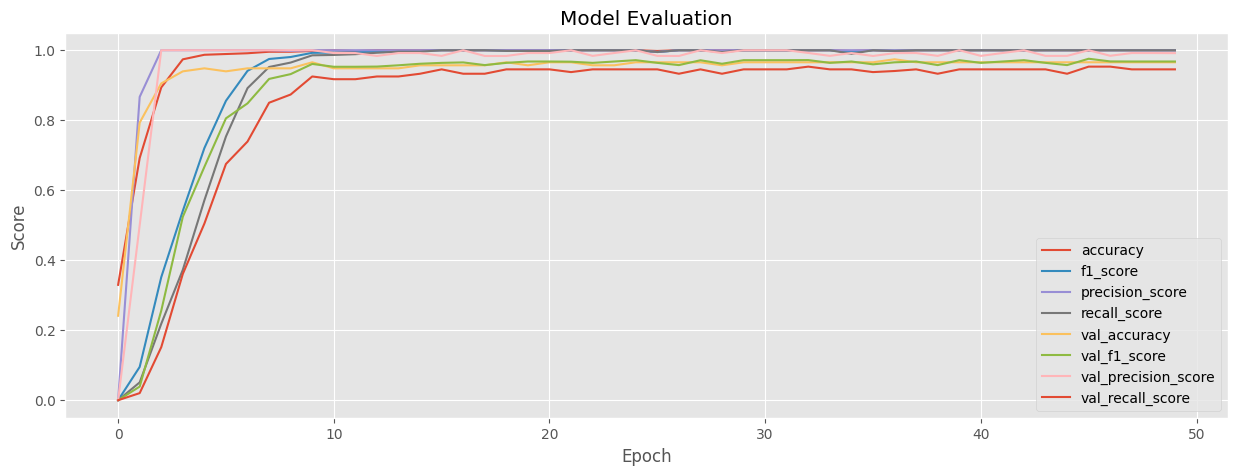

In [30]:
result[["accuracy", "f1_score", "precision_score", "recall_score", 
        "val_accuracy", "val_f1_score", "val_precision_score", "val_recall_score"]].plot(figsize=(15, 5),
                                                                                         title="Model Evaluation",
                                                                                         xlabel="Epoch", 
                                                                                         ylabel="Score")

plt.show()

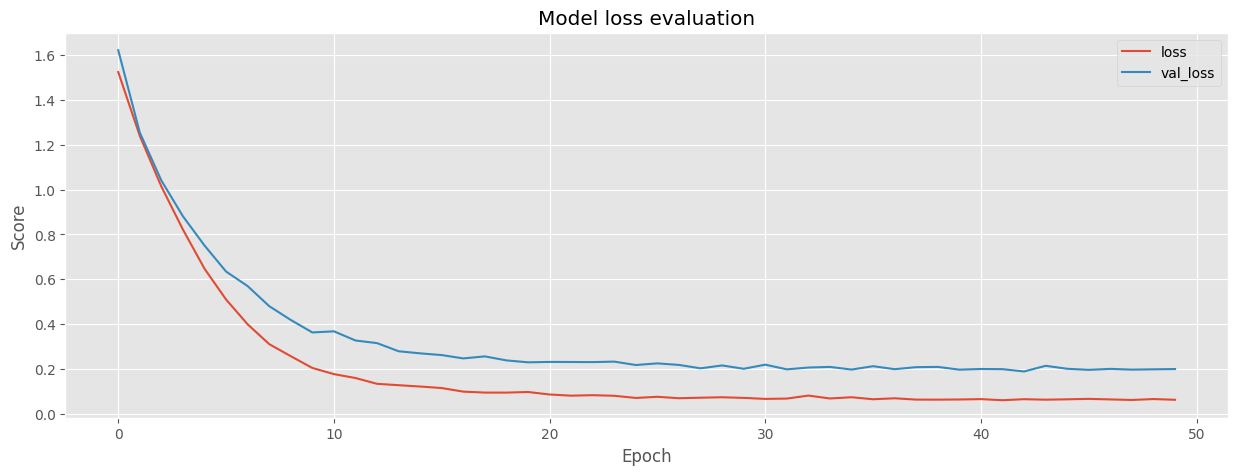

In [31]:
result[["loss", "val_loss"]].plot(figsize=(15, 5),
                                  title="Model loss evaluation",
                                  xlabel="Epoch", 
                                  ylabel="Score")

plt.show()

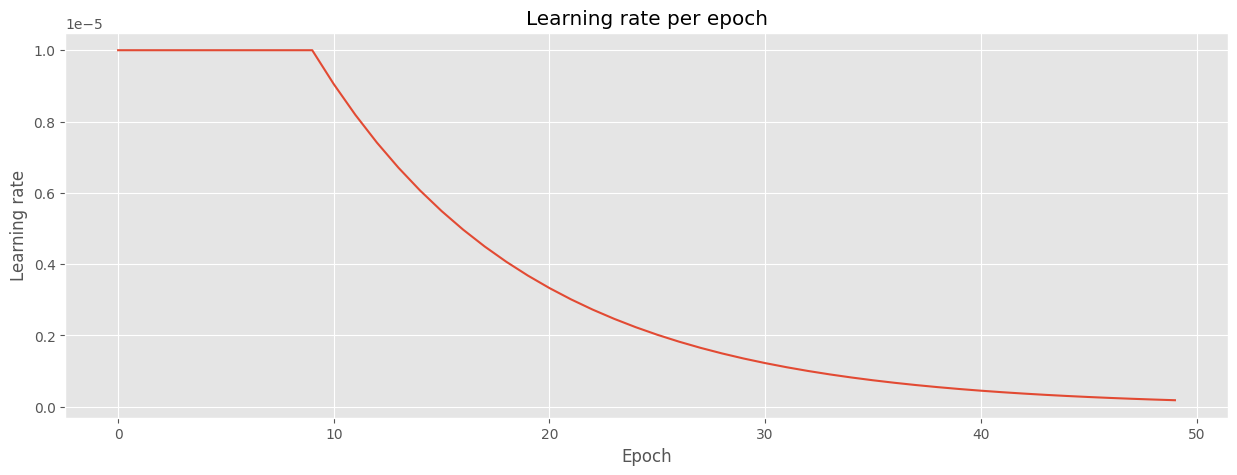

In [32]:
result["learning_rate"].plot(figsize=(15, 5),
                             title="Learning rate per epoch",
                             xlabel="Epoch", 
                             ylabel="Learning rate")

plt.show()

### Prediction on test Set

In [33]:
test_pred = np.argmax(attention_model.predict(Xtest), axis=1)

test_pred

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step

W0000 00:00:1728268066.183056    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.183835    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.184431    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.185023    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.185613    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.186203    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.186791    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.187419    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.188039    3384 gp

8/8 ━━━━━━━━━━━━━━━━━━━━ 118s 9s/step


W0000 00:00:1728268066.794303    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.794999    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.795698    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.796601    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.797362    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.798097    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.798838    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.799544    3384 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1728268066.800329    3384 gp

array([4, 4, 2, 4, 2, 2, 2, 0, 1, 2, 1, 4, 1, 4, 3, 0, 2, 3, 2, 2, 1, 2,
       0, 3, 1, 3, 1, 4, 0, 1, 4, 1, 3, 2, 4, 3, 0, 1, 1, 3, 3, 2, 2, 0,
       3, 0, 1, 2, 0, 1, 2, 4, 4, 3, 3, 0, 0, 1, 0, 1, 1, 0, 0, 0, 3, 2,
       3, 1, 0, 2, 0, 1, 3, 3, 4, 0, 1, 4, 0, 3, 1, 1, 2, 2, 0, 3, 2, 0,
       3, 0, 3, 2, 1, 3, 1, 3, 2, 2, 3, 4, 3, 2, 3, 1, 2, 1, 4, 2, 1, 4,
       0, 2, 2, 3, 3, 2, 2, 4, 2, 0, 4, 2, 3, 2, 4, 2, 4, 3, 1, 4, 2, 3,
       4, 2, 1, 0, 2, 1, 4, 3, 4, 2, 3, 3, 2, 0, 1, 0, 4, 4, 3, 4, 1, 4,
       0, 4, 2, 2, 3, 4, 2, 0, 4, 1, 1, 4, 3, 1, 0, 3, 2, 1, 0, 3, 1, 1,
       1, 1, 4, 3, 3, 4, 4, 0, 3, 1, 0, 1, 0, 4, 0, 4, 2, 0, 3, 3, 1, 2,
       4, 1, 2, 2, 4, 2, 0, 4, 4, 2, 0, 1, 3, 3, 4, 1, 4, 0, 0, 0, 2, 1,
       4, 3, 0, 0, 1, 4, 0, 3, 3, 3, 4, 3, 1, 1, 0, 4, 1, 0, 4, 1, 0, 0,
       0, 0, 4, 0, 4, 4])

In [34]:
ytrue = np.argmax(ytest, axis=1)

ytrue

array([4, 4, 2, 4, 2, 2, 2, 0, 1, 2, 1, 4, 1, 4, 3, 0, 2, 3, 2, 2, 1, 2,
       0, 3, 1, 3, 1, 4, 0, 1, 4, 1, 3, 2, 4, 3, 0, 1, 1, 3, 3, 2, 2, 0,
       3, 0, 1, 2, 0, 1, 2, 4, 4, 3, 3, 0, 0, 1, 0, 1, 1, 0, 0, 0, 3, 2,
       3, 1, 0, 2, 0, 1, 3, 3, 4, 0, 1, 4, 0, 3, 1, 1, 2, 2, 0, 3, 2, 0,
       3, 0, 3, 2, 1, 3, 1, 3, 2, 2, 3, 4, 3, 2, 3, 1, 2, 1, 4, 2, 1, 4,
       0, 2, 2, 3, 3, 2, 2, 4, 2, 0, 4, 2, 3, 2, 4, 2, 4, 3, 1, 4, 2, 3,
       4, 2, 1, 0, 2, 1, 4, 3, 4, 2, 3, 3, 2, 0, 1, 0, 4, 4, 3, 4, 1, 4,
       0, 4, 2, 2, 3, 4, 2, 0, 4, 1, 1, 4, 3, 1, 0, 3, 2, 1, 0, 3, 1, 1,
       1, 1, 4, 3, 3, 4, 4, 0, 3, 1, 0, 1, 0, 4, 0, 4, 2, 0, 3, 3, 1, 2,
       4, 1, 2, 2, 4, 2, 0, 4, 4, 2, 0, 1, 3, 3, 4, 1, 4, 0, 0, 0, 2, 1,
       4, 3, 0, 0, 1, 4, 0, 3, 3, 3, 4, 3, 1, 1, 0, 4, 1, 0, 4, 1, 0, 0,
       0, 0, 4, 0, 4, 4])

## Classification report

In [35]:
print(metrics.classification_report(ytrue, test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        49
           3       1.00      1.00      1.00        49
           4       1.00      1.00      1.00        50

    accuracy                           1.00       248
   macro avg       1.00      1.00      1.00       248
weighted avg       1.00      1.00      1.00       248



## Confusion Matrix

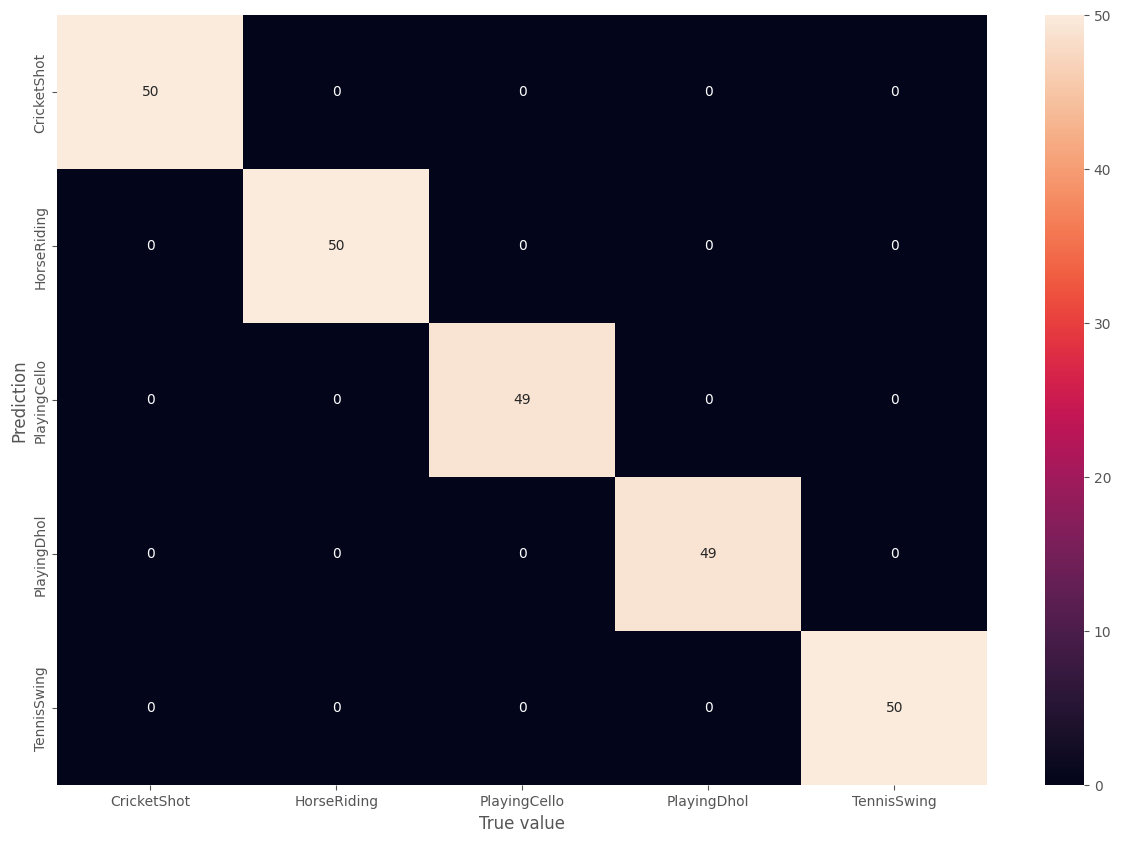

In [36]:
plt.figure(figsize=(15, 10))
cm = metrics.confusion_matrix(ytrue, test_pred)
sns.heatmap(cm,
            annot=True, 
            xticklabels=list(label_index.values()),
            yticklabels=list(label_index.values()))

plt.xlabel("True value")
plt.ylabel("Prediction")
plt.show()

## Eddy